In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

In [30]:
# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [31]:
batch_size = 64
transform = transforms.Compose([transforms.ToTensor()])

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True),
    batch_size=batch_size, shuffle=True
)

In [19]:
# Initialize RBM parameters
visible_units = 784  # 28x28 pixels
hidden_units = 256
learning_rate = 0.005
k = 10  # Increased CD-k steps for better learning

In [32]:
# Initialize weights and biases (here we can experiment with different methods and find the compatible option)
# W = torch.randn(visible_units, hidden_units) * 0.1
# b_v = torch.zeros(visible_units)
# b_h = torch.zeros(hidden_units)

# Xavier (Glorot) Initialization
W = torch.randn(visible_units, hidden_units) * np.sqrt(2 / (visible_units + hidden_units))
b_v = torch.zeros(visible_units)
b_h = torch.zeros(hidden_units)

In [22]:
# Sigmoid activation function
def sigmoid(x):
    return torch.sigmoid(x)

In [33]:
# Move tensors to the device
W = W.to(device)
b_v = b_v.to(device)
b_h = b_h.to(device)

In [34]:
# Training loop
epochs = 100 # (update: 5)
for epoch in range(epochs):
    epoch_loss = 0
    for batch, (data, _) in enumerate(train_loader):
        data = data.to(device)  # Move data to the correct device
        v_0 = data.view(-1, visible_units)  # Flatten the image
        batch_size = v_0.shape[0]  # Get batch size
        
        # Positive phase
        h_prob_0 = sigmoid(torch.matmul(v_0, W) + b_h)  # P(h|v)
        h_0 = (h_prob_0 > torch.rand_like(h_prob_0)).float()  # Sample h 
        
        # Gibbs sampling (CD-k)
        v_k = v_0.clone()
        for _ in range(k):
            h_prob = sigmoid(torch.matmul(v_k, W) + b_h)
            h_k = (h_prob > torch.rand_like(h_prob)).float()
            v_prob = sigmoid(torch.matmul(h_k, W.T) + b_v)
            v_k = v_prob + 0.1 * torch.randn_like(v_prob) # Add nosie to smooth reconstruct
        
        # Negative phase
        h_prob_k = sigmoid(torch.matmul(v_k, W) + b_h)
        
        # Compute gradients
        pos_grad = torch.matmul(v_0.T, h_prob_0)
        neg_grad = torch.matmul(v_k.T, h_prob_k)
        
        # Update weights and biases
        W += learning_rate * (pos_grad - neg_grad) / batch_size
        b_v += learning_rate * torch.mean(v_0 - v_k, dim = 0)
        b_h += learning_rate * torch.mean(h_prob_0 - h_prob_k, dim = 0)
        
        # Compute loss (reconstruction error) (code for later use)
        #batch_loss = torch.mean((v_0 - v_k) ** 2)
        #epoch_loss += batch_loss.item()

        # Compute loss using Mean Absolute Error (L1 Loss)
        batch_loss = torch.nn.functional.l1_loss(v_k, v_0)
        epoch_loss += batch_loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

Epoch 1/100, Loss: 0.1757
Epoch 2/100, Loss: 0.1450
Epoch 3/100, Loss: 0.1378
Epoch 4/100, Loss: 0.1338
Epoch 5/100, Loss: 0.1311
Epoch 6/100, Loss: 0.1291
Epoch 7/100, Loss: 0.1276
Epoch 8/100, Loss: 0.1263
Epoch 9/100, Loss: 0.1252
Epoch 10/100, Loss: 0.1243
Epoch 11/100, Loss: 0.1235
Epoch 12/100, Loss: 0.1228
Epoch 13/100, Loss: 0.1222
Epoch 14/100, Loss: 0.1216
Epoch 15/100, Loss: 0.1210
Epoch 16/100, Loss: 0.1205
Epoch 17/100, Loss: 0.1201
Epoch 18/100, Loss: 0.1196
Epoch 19/100, Loss: 0.1192
Epoch 20/100, Loss: 0.1188
Epoch 21/100, Loss: 0.1184
Epoch 22/100, Loss: 0.1181
Epoch 23/100, Loss: 0.1177
Epoch 24/100, Loss: 0.1174
Epoch 25/100, Loss: 0.1172
Epoch 26/100, Loss: 0.1170
Epoch 27/100, Loss: 0.1167
Epoch 28/100, Loss: 0.1164
Epoch 29/100, Loss: 0.1162
Epoch 30/100, Loss: 0.1160
Epoch 31/100, Loss: 0.1158
Epoch 32/100, Loss: 0.1157
Epoch 33/100, Loss: 0.1155
Epoch 34/100, Loss: 0.1153
Epoch 35/100, Loss: 0.1152
Epoch 36/100, Loss: 0.1150
Epoch 37/100, Loss: 0.1148
Epoch 38/1

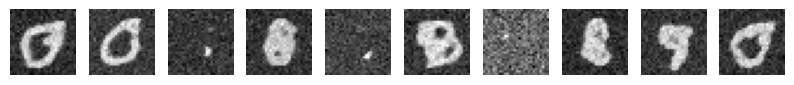

In [42]:
import matplotlib.pyplot as plt

# Number of samples & Gibbs steps
num_samples = 10
num_gibbs_steps = 500 

# Start from real MNIST data instead of pure randomness
sample_data, _ = next(iter(train_loader))  
v = sample_data[:num_samples].view(num_samples, visible_units).to(device)

# Perform Gibbs sampling
for _ in range(num_gibbs_steps):
    h_prob = sigmoid(torch.matmul(v, W) + b_h)
    h_sample = (h_prob > torch.rand_like(h_prob)).float()
    v_prob = sigmoid(torch.matmul(h_sample, W.T) + b_v)
    v = v_prob + 0.1 * torch.randn_like(v_prob)

# Move generated images back to CPU
v = v.detach().cpu()

# Plot generated images
fig, axes = plt.subplots(1, num_samples, figsize=(10, 2.5))
for i in range(num_samples):
    axes[i].imshow(v[i].view(28, 28).numpy(), cmap="gray")
    axes[i].axis("off")
plt.show()

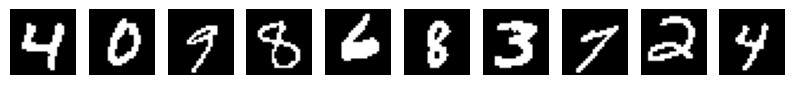

In [13]:
import matplotlib.pyplot as plt

# Get a batch of training data
sample_data, _ = next(iter(train_loader))  
sample_data = sample_data[:10]  # Select 10 images

# Plot the images
fig, axes = plt.subplots(1, 10, figsize=(10, 2))
for i in range(10):
    axes[i].imshow(sample_data[i].view(28, 28).numpy(), cmap="gray")
    axes[i].axis("off")
plt.show()
